In [1]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt

Nous allons nous intéresser à une NAP entérobactérienne aux rôles divers et variés :
Fis (Factor for Inversion Stimulation). En tant que protéine architecturale, Fis module
d’une part la topologie de l’ADN de manière directe et indirecte. Fis agit d’autre part
comme un régulateur global de l’expression des gènes en se ﬁxant de manière as-
péciﬁque sur le génome, avec une préférence pour les régions AT riches.

Nous allons partir directement des données de couverture (i.e. nombre de reads
par position génomique) issues d’un séquençage single-end après contrôle qualité et
alignement. Les auteurs ont choisir de retenir les reads pour lesquels l’alignement avec
la séquence de référence était unique, ne présentait pas de gap et moins de 2 mis-
matches. Chaque alignement a été étendu jusqu’à 200 pb du côté 3’, taille moyenne
des fragments d’ADN dans l’expérience.

Nous allons analyser ces données et comparer les résultats obtenus (proﬁl de ﬁxa-
tion de Fis) à ceux publiés dans l’article.

### Fonction de lissage et réduction à moyenne glissante

In [ ]:
def lissage_reduction(x,y,p):
    '''Lissage et réduction par moyenne glissante sur 2p+1 points'''
    xout = np.empty(0) ; yout = np.empty(0)
    for index in range(p, len(y)-p+1, p):
        xout = np.append(xout,np.mean(x[index-p : index+p+1]))
        yout = np.append(yout,np.mean(y[index-p : index+p+1]))
    return xout,yout

 ### Fonction de chargement d'une séquence fasta

In [ ]:
def load_fasta_seq(filename):
    ''' Chargement sequence genomique a partir d'un fichier fasta'''
    seq = str()
    my_file = open(filename, "r") # ouverture fichier fasta
    for i in my_file.readlines(): # parcourt chaque ligne du fichier
        line=i.strip() # supprrime les retours à la ligne
        if line != '': #si la ligne n'est pas vide
            if line[0]!=">": #et si la ligne n'est pas un entete (les entêtes débutent par >)
                seq+=line
    my_file.close()
    return seq

#### Fonction de calcul du %GC

In [ ]:
def GC_content(seq, window=5000):
    ''' Calcul du taux de GC le long du genome '''
    x = [] ; GC = [] # x coordonnees des fenetres
    for i in range(0,len(seq), window//2):
        s = seq[i: i+window]  
        g = s.count('G') + s.count('g') # nb de G
        c = s.count('C') + s.count('c') # nb de C
        GC.append(float(g+c)/len(s))
        x.append(i+1) # coordonnee debut fenetre
    return x,GC

### Chargement des données de couverture

In [12]:
fisME = pds.read_table('../FisME.blat.basecount.pruned',header=None)
mockME = pds.read_table('../mockip_ME_cov.dat',header=None)

#Nombre de reads (couverture) par position dans la condition Fis
pos, cov = np.asarray(fisME[0],dtype=float), np.asarray(fisME[1],dtype=float)

#Nombre de reads par position dans la condition sans anticorps (mock)
posmock, covmock = np.asarray(mockME[1],dtype=float), np.asarray(mockME[2],dtype=float)


df = pds.DataFrame(data=np.column_stack((pos,cov,covmock)),columns = ["position","couverture fis","couverture mock"])
df.head(10)

,position,couverture fis,couverture mock
0,1.0,68.0,5.0
1,2.0,68.0,7.0
2,3.0,69.0,7.0
3,4.0,69.0,8.0
4,5.0,69.0,8.0
5,6.0,70.0,8.0
6,7.0,70.0,9.0
7,8.0,70.0,12.0
8,9.0,70.0,14.0
9,10.0,70.0,16.0


### Analyse à grande échelle : lissage sur 100 kb

In [14]:
p = 50000 #moyenne sur 2p+1 points (ici, 100001 b)

# Lissage des donneés Fis 
lrpos, lrcov = lissage_reduction(pos,cov, p)

# Lissage des données mock
lrposmock, lrcovmock = lissage_reduction(posmock,covmock, p)


lrdf = pds.DataFrame(data=np.column_stack((lrpos,lrcov,lrcovmock)),columns = ["position lissée","couverture fis lissée","couverture mock lissée"])
lrdf.head(10)

,position lissée,couverture fis lissée,couverture mock lissée
0,50001.0,209.460085,162.949741
1,100001.0,219.905701,169.262237
2,150001.0,221.825502,162.219998
3,200001.0,206.384996,168.377106
4,250001.0,182.536465,160.858921
5,300001.0,179.439966,135.877431
6,350001.0,182.694123,139.599974
7,400001.0,184.363396,151.197438
8,450001.0,197.547055,152.532285
9,500001.0,186.715133,143.989790


La couverture n’est pas du tout homogène à grande échelle : il y a deux fois plus de reads vers l’origine de réplication comparé au terminus de réplication, et ce de manière quasi-identique pour les deux proﬁls Fis / Mock. Cela illustre bien l’eﬀet de la position génomique sur le nombre de reads : certaines régions vont avoir tendance à accumuler les reads indépendemment de la fréquence de ﬁxation de la protéine d’intérêt simplement car elles sont présentes en plus grand nombre de copies dans la cellule.

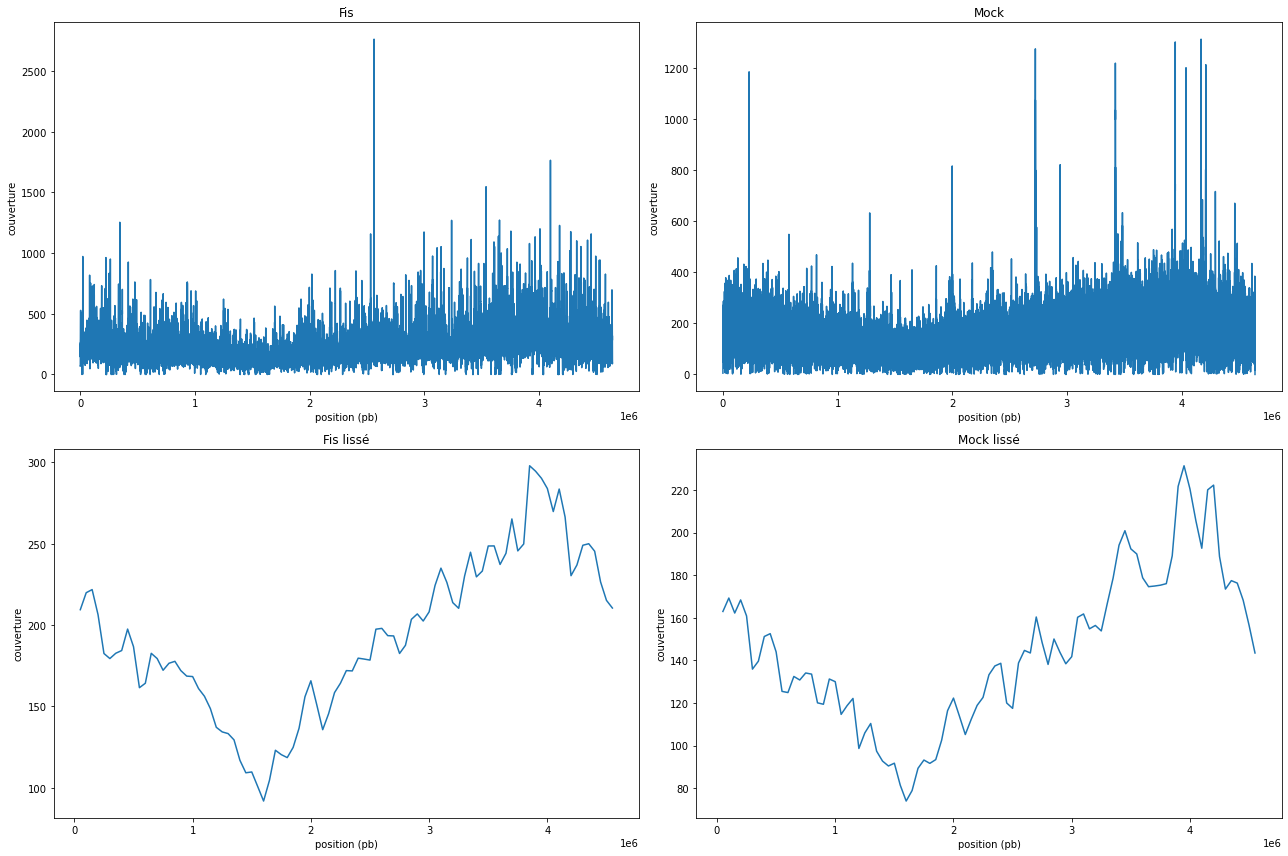

In [20]:
fig = plt.figure(1, figsize=(18, 12))

#rmq : la fonction enumermate sert de compteur, elle commence à 0
for i,(position,couverture,title) in enumerate([(pos,cov,"Fis"),(posmock,covmock,"Mock"),
                                                (lrpos,lrcov,"Fis lissé"),(lrposmock,lrcovmock,"Mock lissé")]) :
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(position,couverture)
    ax.set_title(title)
    ax.set_xlabel("position (pb)")
    ax.set_ylabel("couverture")
    
plt.tight_layout()
plt.show()

### Analyse à échelle intermédiaire : lissage sur 50 kb
+ Le lissage se fait de la même manière avec p = 2500

In [21]:
p = 2500
lrpos, lrcov = lissage_reduction(pos,cov, p)
lrposmock, lrcovmock = lissage_reduction(posmock,covmock, p)

+ Pour que le résultat soit bien visible, on étudie région par région. 
Par exemple entre 1 et 50kb, on sélectionnera les positions et couvertures situées entre 0 et les indices suivants :

In [22]:
index = 50000 - 1 #On soustrait 1 car la numérotation Python commence à 0 (posiiton 1 chromosome = position 0 pour Python)
lrindex = int(index/p) #Après lissage (moyenne glissante), le nombre de points est divisé par p

+ On trace la figure qui représente les conditions mock, Fis avant et après lissage

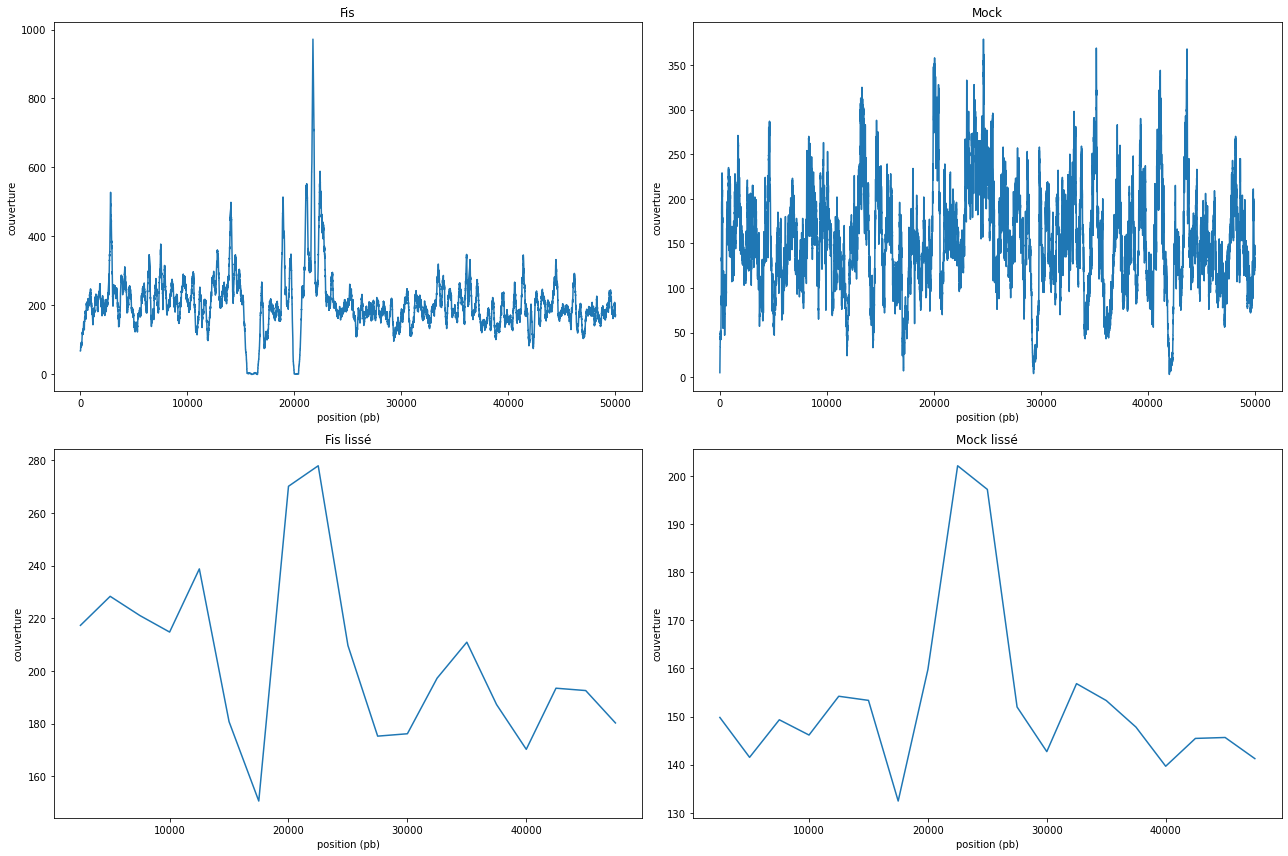

In [23]:
fig = plt.figure(1, figsize=(18, 12))

for i,(position,couverture,title) in enumerate([(pos,cov,"Fis"),(posmock,covmock,"Mock"),
                                                (lrpos,lrcov,"Fis lissé"),(lrposmock,lrcovmock,"Mock lissé")]) :
    ax = fig.add_subplot(2,2,i+1)
    if title in ['Fis','Mock'] :
        ax.plot(position[0:index],couverture[0:index])
    elif title in ['Fis lissé','Mock lissé'] :
        ax.plot(position[0:lrindex],couverture[0:lrindex])
    ax.set_title(title)
    ax.set_xlabel("position (pb)")
    ax.set_ylabel("couverture")
    
plt.tight_layout() 
plt.show()

+ Chargement de la séquence et calcul du %GC le long du chromosome

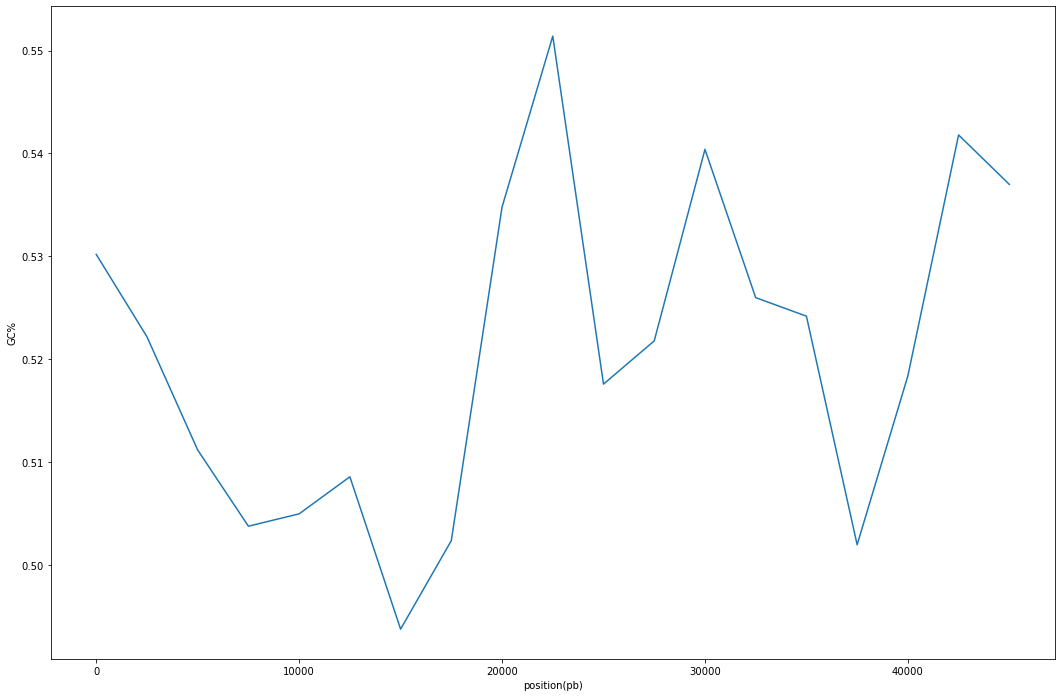

In [26]:
fig = plt.figure(1, figsize=(18, 12))
seq = load_fasta_seq("../ecoli_2011.fasta") # chargement séquence E.coli
x,GC = GC_content(seq) # calcul du contenu en GC le long du génome dans des fenêtres
plt.plot(x[0:lrindex],GC[0:lrindex]) ; plt.ylabel("GC%") ; plt.xlabel("position(pb)")
plt.show()

La couverture n’est pas du tout homogène non plus à échelle intermédiaire : il y a des régions qui ont tendance à accumuler les reads indépendemment de la ﬁxation de la protéine d’intérêt (cf proﬁls quasi-identiques Fis / Mock). La tendance à accumuler des reads corrèle assez bien avec le contenu en GC et illustre bien l’eﬀet de la préférence de séquence dans l’expérience.

### Analyse à faible échelle : 100 pb

In [28]:
p = 50
lrpos, lrcov = lissage_reduction(pos,cov, p)
lrposmock, lrcovmock = lissage_reduction(posmock,covmock, p)
index = 5000 - 1
lrindex = int(index/p)

+ On trace la figure qui représente les conditions mock, Fis avant et après lissage

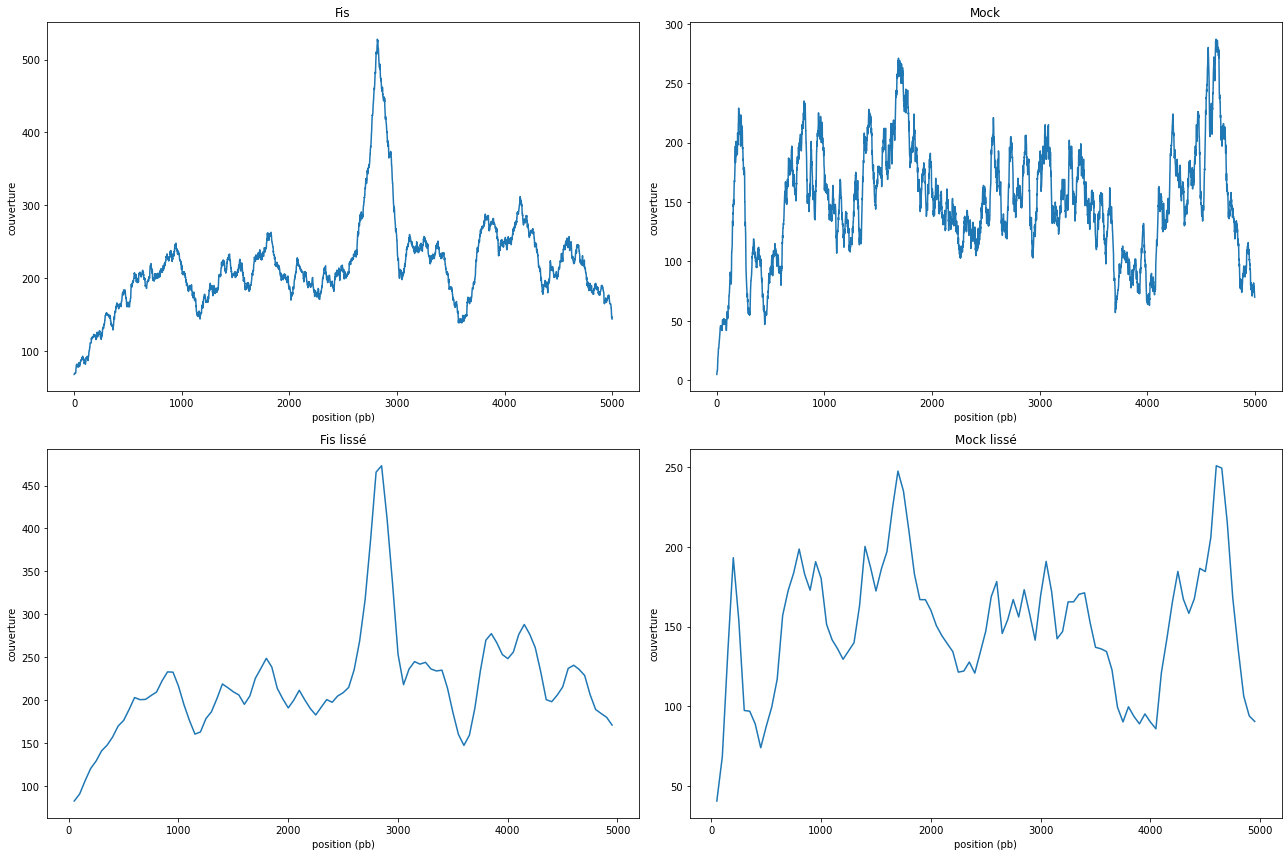

In [29]:
fig = plt.figure(1, figsize=(18, 12))
for i,(position,couverture,title) in enumerate([(pos,cov,"Fis"),(posmock,covmock,"Mock"),
                                                (lrpos,lrcov,"Fis lissé"),(lrposmock,lrcovmock,"Mock lissé")]) :
    ax = fig.add_subplot(2,2,i+1)
    if title in ['Fis','Mock'] :
        ax.plot(position[0:index],couverture[0:index])
    elif title in ['Fis lissé','Mock lissé'] :
        ax.plot(position[0:lrindex],couverture[0:lrindex])
    ax.set_title(title)
    ax.set_xlabel("position (pb)")
    ax.set_ylabel("couverture")
    
plt.tight_layout() 
plt.show()

La couverture n’est pas du tout homogène non plus à faible échelle : il y a des régions qui ont tendance à accumuler les reads indépendemment de la ﬁxation de la protéine d’intérêt. Cela se traduit non seulement par des pics pour Fis mais aussi pour le contrôle, et ce à trois échelles diﬀérentes.

Cela illustre bien l’impact fort de facteurs indépendant de l’évènement de ﬁxation de la protéine étudiée sur le nombre de reads observé e.g. la position génomique (sur-représentation des régions proches de l’origine de réplication car nombre de copies d’ADN plus grand que la moyenne), la préférence de séquence dans l’expérience (sur-représentation des régions riches en GC), l’accés- sibilité de la chromatine (sur-représentation des régions "ouvertes"). On ne donc pas du tout se ﬁer au signal brut pour inférer un proﬁl de ﬁxation. C’est d’ailleurs pour cette raison qu’inférer un proﬁl de ﬁxation ne consiste pas simplement à soustraire le signal du contrôle au signal de l’immunoprécipitation de la protéine d’intérêt et de tester la diﬀérence par rapport à 0 (ou la diﬀérence test / contrôle d’ailleurs) comme dans de nombreuses expériences. Sinon, on va droit dans le mur car on risque de considérer comme sites de ﬁxation en grande partie des sites qui ont tendance à accumuler des reads pour des raisons indépendantes de la ﬁxation elle-même, et pour lesquels un nombre même très faible de reads supplémentaires par rapport au contrôle aboutirait à une diﬀérence signiﬁcative et donc à l’identiﬁcation d’un site. Il est primordial de tra-vailler avec des ratio d’enrichissement !